# Reddit Post Labels — Bar Plot

This notebook:
1. Pulls reddit posts from InfluxDB (measurement: `reddit_post`)
2. Counts the 3 sentiment labels written to `stance_label`
3. Plots a bar chart of label counts

> If your measurement/field names differ (e.g. comments vs posts), adjust the Flux query cell.


In [6]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# If influx_io.py is in the same folder as this notebook, this usually works:
sys.path.insert(0, os.getcwd())

# If it's somewhere else, add that folder too (edit if needed):
# sys.path.insert(0, "/path/to/your/project")

from influx_io import get_client, INFLUX_BUCKET, INFLUX_ORG


In [7]:
def load_reddit_posts_with_labels(lookback: str = "30d", limit: int = 10000) -> pd.DataFrame:
    """
    Loads reddit posts that already have a stance_label.
    Returns a DataFrame with at least: _time, usid, source, title, selftext, stance_label
    """
    with get_client() as client:
        query_api = client.query_api()
        flux = f"""
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -{lookback})
  |> filter(fn: (r) => r._measurement == "reddit_post")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time","usid","source","title","selftext","stance_label"])
  |> filter(fn: (r) => exists r.stance_label and r.stance_label != "")
  |> limit(n: {int(limit)})
"""
        tables = query_api.query(flux, org=INFLUX_ORG)

    rows = []
    for t in tables:
        for rec in t.records:
            v = rec.values
            rows.append({
                "_time": v.get("_time"),
                "usid": v.get("usid"),
                "source": v.get("source"),
                "title": v.get("title") or "",
                "selftext": v.get("selftext") or "",
                "stance_label": v.get("stance_label") or "",
            })

    return pd.DataFrame(rows)

df = load_reddit_posts_with_labels(lookback="30d", limit=10000)
df.head(), len(df)


(                      _time          usid      source  \
 0 2026-01-06 12:53:14+00:00  news:3417172  AlgosOneAI   
 1 2025-12-29 06:26:25+00:00  news:3417135     Austria   
 2 2025-12-24 23:40:10+00:00  news:3417166     Austria   
 3 2025-12-16 12:55:06+00:00  news:3417168     Austria   
 4 2025-12-21 21:18:23+00:00  news:3417168     Austria   
 
                                                title  \
 0                             Punkt 7.6 AGB Algosone   
 1  Neue Familien-Statistik veröffentlicht: Geburt...   
 2  2025 hat mir gezeigt wieso öffentlich-rechtlic...   
 3                   Zukunft von Wien-Flügen ungewiss   
 4  Kind warf Minifeuerwerkskörper von Lift und lö...   
 
                                             selftext stance_label  
 0  Hallo zusammen ich wurde von AlgosOne auf die ...      neutral  
 1  Hier ein paar grobe Fakten aus dem ORF und TT ...      neutral  
 2  Es ist ja kein Geheimnis dass viele von uns mi...      neutral  
 3  Ich hoffe mal der Koralmtu

In [8]:
# Count the 3 labels
counts = df["stance_label"].value_counts().sort_index()
counts


stance_label
negative    28
neutral     35
positive     3
Name: count, dtype: int64

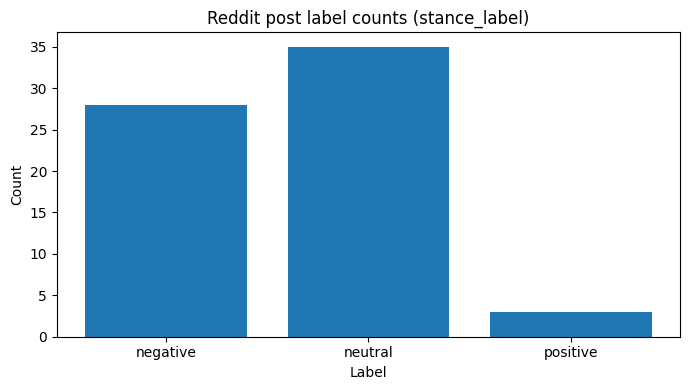

In [9]:
# Bar plot (no explicit colors per best practice)
plt.figure(figsize=(7,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Reddit post label counts (stance_label)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


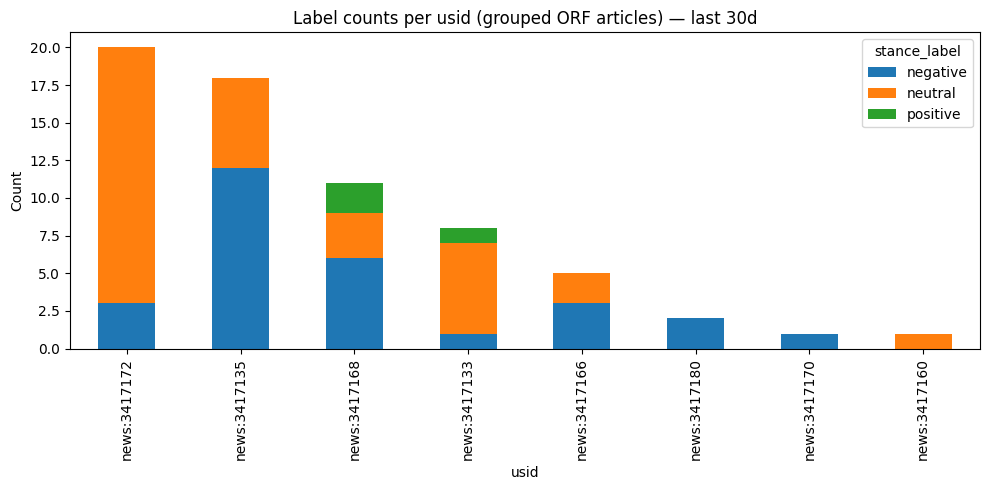

stance_label,negative,neutral,positive
usid,,,
news:3417172,3,17,0
news:3417135,12,6,0
news:3417168,6,3,2
news:3417133,1,6,1
news:3417166,3,2,0
news:3417180,2,0,0
news:3417170,1,0,0
news:3417160,0,1,0


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

LOOKBACK = "30d"   # adjust (e.g. "180d")
LIMIT = 100000     # adjust if needed
TOP_N = 10        # show top N usids (most rows). set None to show all (can get messy)

# --- Load labeled reddit posts from Influx ---
with get_client() as client:
    q = client.query_api()
    flux = f"""
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -{LOOKBACK})
  |> filter(fn: (r) => r._measurement == "reddit_post")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time","usid","stance_label"])
  |> filter(fn: (r) => exists r.stance_label and r.stance_label != "")
  |> limit(n: {int(LIMIT)})
"""
    tables = q.query(flux, org=INFLUX_ORG)

rows = []
for t in tables:
    for rec in t.records:
        v = rec.values
        rows.append({
            "_time": v.get("_time"),
            "usid": v.get("usid"),
            "stance_label": v.get("stance_label") or "",
        })

df = pd.DataFrame(rows)

if df.empty:
    print("No labeled reddit_post rows found.")
else:
    df["stance_label"] = df["stance_label"].astype(str).str.lower()

    # Count labels per usid
    counts = (
        df.groupby(["usid", "stance_label"])
          .size()
          .unstack(fill_value=0)
    )

    # Ensure the 3 expected columns exist (and order them)
    for col in ["negative", "neutral", "positive"]:
        if col not in counts.columns:
            counts[col] = 0
    counts = counts[["negative", "neutral", "positive"]]

    # Choose which usids to plot
    if TOP_N:
        counts = counts.sort_values(by=["negative","neutral","positive"], ascending=False)
        # better: sort by total rows
        counts["total"] = counts.sum(axis=1)
        counts = counts.sort_values("total", ascending=False).drop(columns=["total"]).head(TOP_N)

    # Plot stacked bars (one bar per usid)
    ax = counts.plot(kind="bar", stacked=True, figsize=(max(10, len(counts)*1.2), 5))
    ax.set_title(f"Label counts per usid (grouped ORF articles) — last {LOOKBACK}")
    ax.set_xlabel("usid")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Optional: display the underlying table
    display(counts)
